# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [2]:
import rebound
import numpy as np

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [4]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
        particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0009430431780131822 y=0.007473248698536717 z=-5.2569428608146686e-05 vx=-0.0004640679386496118 vy=0.00010305027984649251 vz=1.1946420242630871e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.97260406558937 y=-4.957941345549425 z=0.06468753254183474 vx=0.40233110926077004 vy=-0.14124944149783675 vz=-0.008413757092705665>
<rebound.Particle object

Let's save this simulation for future reference.

In [6]:
sim.save("solar_system_outer_planets.bin")

In [3]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [52]:
def simulate_fly_by(sim, intruder, visualize=False):
    intruder.hash = "intruder"
    
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+5)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            #print(error)
            for i, particle in enumerate(sim.particles):
                distance = np.linalg.norm(particle.xyz)
                if distance > sim.exit_max_distance:
                    #print("Removed", i, str(particle.hash))
                    sim.remove(hash=particle.hash)
                    sim.move_to_com()
                    
            return sim


In [53]:
def calc_escape_velocity(sim, particle):
    #sim.move_to_hel()
    
    r = np.linalg.norm(particle.xyz)
    G = sim.G
    m = sim.particles[0].m
    
    return np.sqrt(2 * G * m / r)

In [54]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's orbits properties.

In [ ]:
def analyze_stability(sim):
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    

In [61]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            return True
    
    return False
    


In [17]:
def check_kozai(sim):
    # compare all particles
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True
    
    return False
            

In [57]:
xs, f_eject = strong_regime(resolution=30, n_trials=5000)

plt.plot(xs, f_eject)

Starting strong regime simulation with resolution 30, 5000 trials each...
Running r_min = 1.0


/home/simon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Detected 5000.0 ejections out of 5000 trials.
1.0
Running r_min = 2.689655172413793


KeyboardInterrupt: 

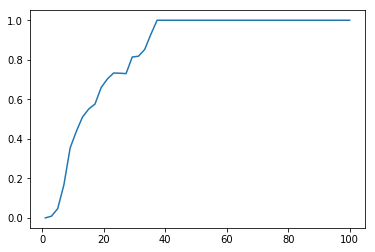

In [50]:
plt.plot(xs, 1-f_eject)

In [32]:
a = np.ones(10)
a[2] = 5
a


array([1., 1., 5., 1., 1., 1., 1., 1., 1., 1.])

In [55]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

In [60]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
simulate_fly_by(sim, intruder, visualize=True)

In [13]:
sim.particles[4].inc

0.030897078503559147